In [21]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
from collections import OrderedDict
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct, groupby, chain
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [22]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment.62pA_true_events.pickle",
     "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
#     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
}

In [23]:
NMER = 5
CONTEXT = 200

In [24]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [25]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [26]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>burn-in lambda_ref']
GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACC


In [27]:
def get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    context = ref[start:end]
    if len(context) != end-start:
        print(start, end, len(ref), len(context), end-start)
        raise IndexError
    else: return context

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = int(-floor(length/2))
    return get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = int(floor(length/2) + 1)
    return get_context(event, offset, offset+n)

In [28]:
test_event = true_events[1024]
assert test_event['kmer'] == get_context(test_event, -2, 2+1), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    get_context(test_event, -22, 22+1))

## Analysis 

In [29]:
all_5mers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_5mers)

In [30]:
def prepare_events(kmer):
    template_events = [ev for ev in ev_map[kmer] if not np.isnan(ev["template.mean"])]
    template_events = [ev for ev in template_events if 
                   ev["ref_position"] > CONTEXT+NMER+1 and ev["ref_position"] < len(ref)-CONTEXT-NMER-1]
    print("kmer {0}".format(kmer))
    print(">>genomic_positions {0}".format(len(set([ev["ref_position"] for ev in template_events]))))
    print(">>total_events {0}".format(len(template_events)))
    return template_events

In [31]:
def stratify_by_position(template_events, skip=10):
    """group events by genomic positions. 
    
    Args: 
        template_events: list of events
        skip: skip genomic positions with less than {skip} events. 
    
    Returns: 
        dict pos => (mean, stdv, context_before, context_after) of the
        given position. 
    """
    sort_position = lambda x: x["ref_position"]
    template_events = sorted(template_events, key=sort_position)
    groups = {key: [x for x in group] for key, group in groupby(template_events, sort_position)}
    genomic_pos = OrderedDict()
    for key, group in groups.items():
        means = [x["template.mean"] for x in group]
        if(len(means) < skip): 
            print("skipped {0}".format(key))
            continue
        else:
            assert get_context_before(group[0], CONTEXT) == get_context_before(group[-1], CONTEXT)
            genomic_pos[key] = {
                "event_means" : means,
                "mean" : np.mean(means),
                "stdv" : np.std(means),
                "context_before": get_context_before(group[0], CONTEXT),
                "context_after": get_context_after(group[0], CONTEXT)
        }
    
    return genomic_pos                                                       

kmer ACTGC
>>genomic_positions 58
>>total_events 1273


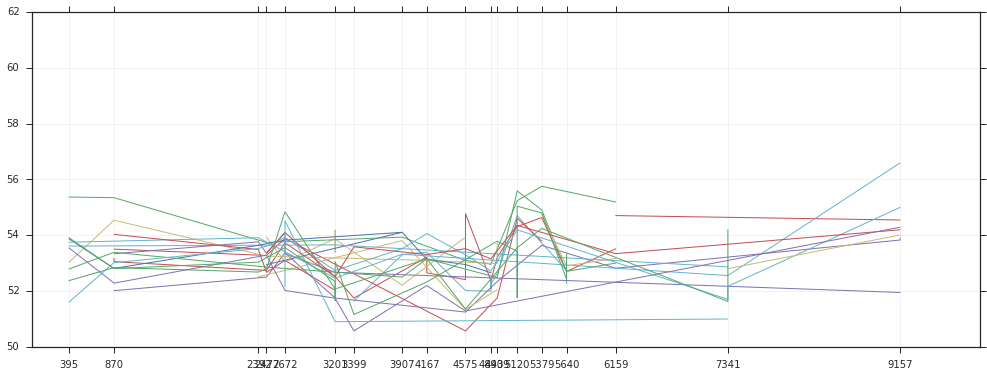

In [32]:
for kmer in ["ACTGC"]:
    fig, ax = subplots(figsize=(17,6))
    template_events = prepare_events(kmer)
    sort_key = lambda x: "{0:3}_{0:3}".format(x["channel"], x["file_id"])
    template_events = [x for x in template_events if 0 < x["ref_position"] < 10000]
    template_events = sorted(template_events, key=sort_key)
    groups = {key: [x for x in group] for key, group in groupby(template_events, sort_key)}
    plot_values = [sorted([(x["ref_position"], x["template.mean"]) for x in group], key=lambda k: k[0]) for group in groups.values()]
    for v in plot_values[:]: 
        diff = v[0][1] - 55
        diff = 0
        ax.plot([x[0] for x in v], [x[1] - diff for x in v], lw=1)
    ax.set_ylim((50, 62))
    ax.set_xticks(sorted(list(set([x[0] for x in chain(*plot_values)]))))
    display(fig)
    plt.close()

In [33]:
pos =[i+2 for i, _ in enumerate(ref) if ref[i:i+5] == "ACTGC"]

In [34]:
template_events = prepare_events("ACTGC")
genomic_pos = stratify_by_position(template_events, skip=0)
print(pos, sorted([x for x in genomic_pos.keys()]))
assert sorted(genomic_pos.keys()) == sorted(pos)

kmer ACTGC
>>genomic_positions 58
>>total_events 1273
[395, 870, 2392, 2477, 2672, 3201, 3399, 3907, 4167, 4575, 4843, 4909, 5120, 5379, 5640, 6159, 7341, 9157, 11443, 14704, 16425, 16870, 17390, 19422, 19706, 22514, 23983, 24329, 24931, 25519, 26928, 27433, 27627, 27948, 29985, 30850, 31552, 31661, 32081, 32379, 32538, 32682, 35080, 36732, 37806, 39939, 40138, 41638, 42134, 42331, 42376, 42790, 44171, 45871, 46662, 47954, 48028, 48042] [395, 870, 2392, 2477, 2672, 3201, 3399, 3907, 4167, 4575, 4843, 4909, 5120, 5379, 5640, 6159, 7341, 9157, 11443, 14704, 16425, 16870, 17390, 19422, 19706, 22514, 23983, 24329, 24931, 25519, 26928, 27433, 27627, 27948, 29985, 30850, 31552, 31661, 32081, 32379, 32538, 32682, 35080, 36732, 37806, 39939, 40138, 41638, 42134, 42331, 42376, 42790, 44171, 45871, 46662, 47954, 48028, 48042]


In [35]:
for i in range(len(pos) - 1): 
    print(pos[i], pos[i+1] - pos[i])

395 475
870 1522
2392 85
2477 195
2672 529
3201 198
3399 508
3907 260
4167 408
4575 268
4843 66
4909 211
5120 259
5379 261
5640 519
6159 1182
7341 1816
9157 2286
11443 3261
14704 1721
16425 445
16870 520
17390 2032
19422 284
19706 2808
22514 1469
23983 346
24329 602
24931 588
25519 1409
26928 505
27433 194
27627 321
27948 2037
29985 865
30850 702
31552 109
31661 420
32081 298
32379 159
32538 144
32682 2398
35080 1652
36732 1074
37806 2133
39939 199
40138 1500
41638 496
42134 197
42331 45
42376 414
42790 1381
44171 1700
45871 791
46662 1292
47954 74
48028 14
